# Selección de Modelo + Tuning de Hiperparámetros  + Evaluación final del mejor modelo: k Fold Cross Validation Anidado

## INTRODUCCIÓN 
Con el método " Separando el Test Set" al efectuar la comparación entre diferentes algoritmos o modelos, utilizamos el mismo Test Set para evaluar cada uno de los modelos. Ésto provocará que aprendamos "algo" del Test Set (ya que en base a él elegiríamos el mmodelo que mejor resultado dio), y la evaluación del mismo sería algo **optimista**.

Una forma de intentar resolver este problema  es ... aplicando Cross Validation sobre todo el DataSet Original, de tal forma de ir "rotando" el Test Set, para lo cual deberíamos repetir el proceso de la siguiente imagen para diversos folds en los que habríamos dividido al DataSet original completo.

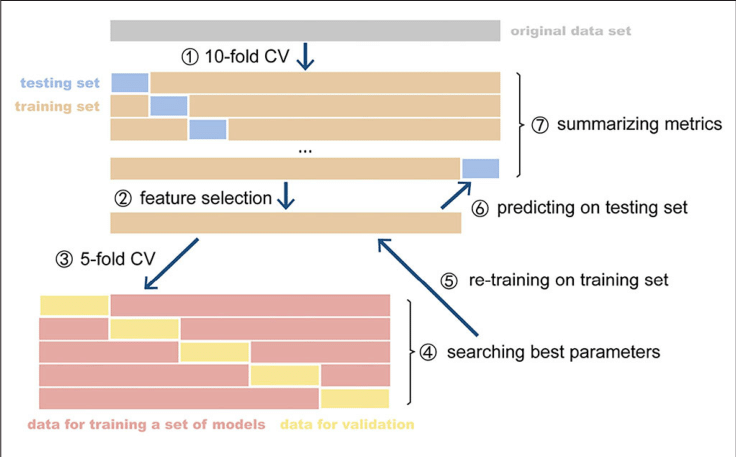

Al loop más externo, el que divide al DataSet en diversos folds se lo suele denominar "loop externo" o "outer loop", al que se produce al dividir el Train también en folds, se lo suele denominar "loop interno"o "internal loop".

**El loop interno se utiliza sólo para determinar el algoritmo**. Un vez determinado el algoritmo que mejor funciona, entonces utilizaremos el loop externo para determinar el mejor valor de sus hiperparámetros y estimar una evaluación del modelo así elegido. 

## Librerias

In [ ]:
import numpy as np
import pandas as pd

# CV
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_validate

# modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


import random
np.random.seed(123)
random.seed(123)

## Los Datos

In [ ]:
df=pd.read_csv('/content/datos1.csv')


X=df.drop('y', axis='columns')
y=df['y']

## Creación del inner fold y outer fold

In [ ]:
# Creamos los folds externos
skfold_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Creamos los folds internos
skfold_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

## Desarrollamos cada uno de los modelos

Probamos con KNN

In [ ]:
# Instanciamos el estimador
KNN=KNeighborsClassifier(algorithm='ball_tree', leaf_size=50)

# Creamos la grilla de hiperparametros a probar
param_grid_knn = [{'n_neighbors': list(range(1, 10)),'p': [1, 2]}]

# Creamos el inner CV (GSCV para buscar los mejores hiperparámetros con los k folds internos)
gscv_knn = GridSearchCV(estimator=KNN,
                    param_grid=param_grid_knn, 
                    scoring='accuracy',
                    n_jobs=-1,
                    cv=skfold_inner,
                    verbose=0,
                    refit=True)

# Ahora creamos el outer CV para evaluar el inner CV para cada fold externo
# Recordar que cross_val_score/cross_validate realiza el .fit y .predict internamente
# Tener en cuenta que el .predict lo realiza sobre el modelo que tuvo mejores resultados en el entrenamiento (gscv_knn.best_estimator_)
nested_cv_knn = cross_validate(gscv_knn, X=X, y=y, cv=skfold_outer, return_train_score=True)

result_cv_knn = pd.DataFrame(nested_cv_knn)
result_cv_knn

,fit_time,score_time,test_score,train_score
0,2.151358,0.004794,1.0,0.925
1,0.482662,0.002858,1.0,0.925
2,0.372546,0.002757,1.0,1.000
3,0.349947,0.002816,0.9,1.000
4,0.345420,0.004762,1.0,1.000


Árbol

In [ ]:
# Instanciamos el estimador
DTREE=DecisionTreeClassifier(random_state=1)

# Creamos la grilla de hiperparametros a probar
param_grid_dtree =[{'max_depth': list(range(1, 10)) + [None],
                        'criterion': ['gini', 'entropy']}]

# Creamos el inner CV (GSCV para buscar los mejores hiperparámetros con los k folds internos)
gscv_dtree = GridSearchCV(estimator=DTREE,
                    param_grid=param_grid_dtree, 
                    scoring='accuracy',
                    n_jobs=-1,
                    cv=skfold_inner,
                    verbose=0,
                    refit=True)

# Ahora creamos el outer CV para evaluar el inner CV para cada fold externo
nested_cv_dtree = cross_validate(gscv_dtree, X=X, y=y, cv=skfold_outer, return_train_score=True)

result_cv_dtree = pd.DataFrame(nested_cv_dtree)
result_cv_dtree

,fit_time,score_time,test_score,train_score
0,0.310290,0.001648,0.8,0.975
1,0.320016,0.001742,0.9,0.950
2,0.291204,0.001706,1.0,1.000
3,0.307908,0.001677,0.8,0.975
4,0.302042,0.001783,1.0,0.950


Regresión Logistica con Ridge

In [ ]:
# Instanciamos el estimador
RIDGE=LogisticRegression(penalty='l2', max_iter=10000, tol=0.0001)

# Creamos la grilla de hiperparametros a probar
param_grid_ridge = [{'C':[1e-6,1e-5,1e-4,0.001,0.01,0.1,1,10]}]

# Creamos el inner CV (GSCV para buscar los mejores hiperparámetros con los k folds internos)
gscv_ridge = GridSearchCV(estimator=RIDGE,
                    param_grid=param_grid_ridge, 
                    scoring='accuracy',
                    n_jobs=-1,
                    cv=skfold_inner,
                    verbose=0,
                    refit=True)

# Ahora creamos el outer CV para evaluar el inner CV para cada fold externo
nested_cv_ridge = cross_validate(gscv_ridge, X=X, y=y, cv=skfold_outer, return_train_score=True)

result_cv_ridge = pd.DataFrame(nested_cv_ridge)
result_cv_ridge

,fit_time,score_time,test_score,train_score
0,0.231591,0.001934,1.0,0.925
1,0.273081,0.007654,0.9,0.975
2,0.366682,0.003292,1.0,0.925
3,0.334720,0.003440,0.8,0.975
4,0.368367,0.003464,1.0,0.925


### SELECCIÓN DE ALGORITMO

Buscamos el "mejor" modelo (algoritmo) **promediando** los valores obtenidos por cada modelo en  los folds del **outer**:

In [ ]:
KNN_promedio = result_cv_knn.test_score.mean()
KNN_desvio = result_cv_knn.test_score.std()

DTREE_promedio = result_cv_dtree.test_score.mean()
DTREE_desvio = result_cv_dtree.test_score.std()

RIDGE_promedio = result_cv_ridge.test_score.mean()
RIDGE_desvio = result_cv_ridge.test_score.std()

print('KNN promedio en el outer: ',KNN_promedio*100, " +/- ", 2*KNN_desvio*100, " (95%)")
print('DTREE promedio en el outer: ', DTREE_promedio*100, " +/- ", 2*DTREE_desvio*100, " (95%)")
print('RIDGE promedio en el outer: ', RIDGE_promedio*100, " +/- ", 2*RIDGE_desvio*100, " (95%)")

KNN promedio en el outer:  98.00000000000001  +/-  8.944271909999157  (95%)
DTREE promedio en el outer:  90.0  +/-  19.999999999999996  (95%)
RIDGE promedio en el outer:  94.0  +/-  17.888543819998315  (95%)


> Elegimos el **algoritmo** que mejor anduvo **pero no nos interesan los hiperparámetros utilizados en el inner**, éstos sólo sirvieron para comparar los algoritmos y elegir el que mejor anduvo.  El **inner** sólo nos sirvió para saber qué algoritmo vamos a usar.

> Ahora vamos a repetir el proceso de Cross Validation con todos los datos, **para el algoritmo elegido**, y **descubriremos sus mejores hiperparámetros**.

> Pero sí debemos utlizar **el mismo grid de hiperparámetros que utilizamos antes en el inner**. No podemos usar uno con más valores por ejemplo.

El algoritmo elegido es knn, fíjese que en el GridSearchCV gscv_knn tenemos cargada la grilla de parámetros que usamos anteriormente, así que  no necesitamos escribirla de nuevo!

In [ ]:
gscv_knn

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=KNeighborsClassifier(algorithm='ball_tree',
                                            leaf_size=50),
             n_jobs=-1,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'p': [1, 2]}],
             scoring='accuracy')

## Evaluación del Modelo / Hiperparámetros elegido

Entrenamos con fit al algoritmo elegido usando Cross Validation por eso usamos el GridSearchCV   

In [ ]:
algoritmo_elegido = gscv_knn
algoritmo_elegido.fit(X, y)

elegido_resultados = pd.DataFrame(algoritmo_elegido.cv_results_).loc[algoritmo_elegido.best_index_]

elegido_promedio = elegido_resultados.mean_test_score
elegido_desvio = elegido_resultados.std_test_score

print('AC: ', elegido_promedio*100, " +/- ", 2*elegido_desvio*100, " (95%)")

AC:  100.0  +/-  0.0  (95%)


In [ ]:
algoritmo_elegido.best_params_

{'n_neighbors': 3, 'p': 2}

## Bibliografía

* https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

* https://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html